### NLP建模，可用于科研实验、企业建模
#### 功能包括：
- 1.数据预处理
- 2.数据集构建
- 3.预训练词向量应用
- 4.模型训练、评估、预测
- 5.模型线上化，保存java可调用模型文件
- 6.精细化模型评估

In [1]:
# coding: UTF-8

import pandas as pd
import os
import torch
import numpy as np
import pickle as pkl
from tqdm import tqdm
import time
from datetime import timedelta
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
import datetime
from tensorboardX import SummaryWriter
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

/Users/chenzhong72/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_df = pd.read_csv("dataset/train.txt",sep = "\t")
test_df = pd.read_csv("dataset/test.txt",sep = "\t")

In [3]:
train_df.label.value_counts()

0    8564
1    4236
Name: label, dtype: int64

In [4]:
test_df.label.value_counts()

0    2115
1    1085
Name: label, dtype: int64

## 数据集切分

In [5]:
from sklearn.model_selection import train_test_split

train,valdate  = train_test_split(train_df, test_size = 0.2,random_state = 110)

In [6]:
train["data_category"]  = "train"
valdate["data_category"]  = "valdate"
test_df["data_category"]  = "test"

In [7]:
data = train.append(valdate).append(test_df)

/var/folders/zn/52tvsv3d51zc1jvgg_8vq2bw0000gp/T/ipykernel_32077/1770443426.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = train.append(valdate).append(test_df)
/var/folders/zn/52tvsv3d51zc1jvgg_8vq2bw0000gp/T/ipykernel_32077/1770443426.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = train.append(valdate).append(test_df)


# 1、数据预处理

## 1.1 Unicode Nomalization

In [8]:
# 暂无需使用

text = "GeeksForGeeks ????"
print(text.encode('utf-8'))

b'GeeksForGeeks ????'


## 1.2 剔除字符空格数字等

In [9]:
import re
def data_re(sentence):
    # 过滤不了\\ \ 中文（）还有————
    r1 = u'[a-zA-Z0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'#用户也可以在此进行自定义过滤字符 
    # 者中规则也过滤不完全
    r2 = "[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+"
    # \\\可以过滤掉反向单杠和双杠，/可以过滤掉正向单杠和双杠，第一个中括号里放的是英文符号，第二个中括号里放的是中文符号，第二个中括号前不能少|，否则过滤不完全
    r3 =  "[.!//_,$&%^*()<>+\"'?@#-|:~{}]+|[——！\\\\，。=？、：“”‘’《》【】￥……（）]+" 
    # 去掉括号和括号内的所有内容
    r4 =  "\\【.*?】+|\\《.*?》+|\\#.*?#+|[.!/_,$&%^*<>+""'?@|:~{}#]+|[——！\\\，。=？、：“”‘’￥……（）《》【】]"

    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #去除html标签

    
    sentence = re.sub(r1,'',sentence)
    sentence = re.sub(r2,'',sentence)
    sentence = re.sub(r4,'',sentence)
    
    
#     sentence = re.sub(r"\d+", '',sentence)  # 仅去除数字 d即为数字
    return sentence

In [10]:
data['text_clean'] = data['text'].map(lambda x :x if pd.isnull(x) else data_re(x) )

In [11]:
data['text_clean'].head(5)

1745     味道一如既往的好吃
7529      东西一如既往的好
11487     生日快到的前几天
4410       鹅肝寿司是最爱
10422     面包烤的恰到好处
Name: text_clean, dtype: object

## 1.3 分词

In [12]:
import jieba
def cut_word(x):
    if pd.isnull(x):
        return x
    else:
        cw = jieba.cut(x)
        return list(cw)

In [13]:
data['clean_cut_word'] = data['text_clean'].apply(cut_word)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/zn/52tvsv3d51zc1jvgg_8vq2bw0000gp/T/jieba.cache
Loading model cost 0.653 seconds.
Prefix dict has been built successfully.


## 1.4 剔除停用词

In [14]:
import nltk
# nltk.download('punkt')
from nltk.corpus import stopwords

# nltk.download('stopwords')
stop_words = stopwords.words('chinese')

In [15]:
data['text_restopwords'] = data['clean_cut_word'].map(lambda x :[item for item in x 
                                                                            if item  not in stop_words])

In [16]:
data.head(5)

,label,text,data_category,text_clean,clean_cut_word,text_restopwords
1745,0,味道一如既往的好吃,train,味道一如既往的好吃,"[味道, 一如既往, 的, 好吃]","[味道, 一如既往, 好吃]"
7529,0,东西一如既往的好,train,东西一如既往的好,"[东西, 一如既往, 的, 好]","[东西, 一如既往, 好]"
11487,0,生日快到的前几天,train,生日快到的前几天,"[生日, 快到, 的, 前, 几天]","[生日, 快到, 前, 几天]"
4410,1,鹅肝寿司是最爱,train,鹅肝寿司是最爱,"[鹅, 肝, 寿司, 是, 最, 爱]","[鹅, 肝, 寿司, 最, 爱]"
10422,1,面包烤的恰到好处,train,面包烤的恰到好处,"[面包, 烤, 的, 恰到好处]","[面包, 烤, 恰到好处]"


In [17]:
data.data_category.value_counts()

train      10240
test        3200
valdate     2560
Name: data_category, dtype: int64

#### 当前建模文本采用【剔除字符空格数字】处理的文本，即text_clean

In [18]:
save_features = ["text_clean","label"]

In [19]:
for i in set(data.data_category):
    data[data["data_category"]==i][save_features].to_csv("dataset/after_process_"+i+".csv",
                                                         index = False, sep = "\t",header = None)

# 2、构建预训练词向量

In [20]:
train_path = "dataset/after_process_train.csv"
val_path = "dataset/after_process_valdate.csv"
test_path = "dataset/after_process_test.csv"

In [21]:
def build_vocab(file_path, tokenizer, max_size, min_freq):
    vocab_dic = {}
    with open(file_path, 'r', encoding='UTF-8') as f:
        for line in tqdm(f):
            lin = line.strip()
            if not lin:
                continue
            content = lin.split('\t')[0]
            for word in tokenizer(content):
                vocab_dic[word] = vocab_dic.get(word, 0) + 1

        vocab_list = sorted([_ for _ in vocab_dic.items() if _[1] >= min_freq], key=lambda x: x[1], reverse=True)[:max_size]
        vocab_dic = {word_count[0]: idx for idx, word_count in enumerate(vocab_list)}
        vocab_dic.update({UNK: len(vocab_dic), PAD: len(vocab_dic) + 1})
    return vocab_dic

In [22]:
MAX_VOCAB_SIZE = 10000  # 词表长度限制
embedding_size = 300
UNK, PAD = '<UNK>', '<PAD>'  # 未知字，padding符号
sequence_length = 128
device = "cpu"


# 下面的目录、文件名按需更改。
train_dir = "dataset/after_process_train.csv"
vocab_dir = "Word2vec/Word2vec.pkl"
pretrain_dir = "Word2vec/sgns.wiki.bigram-char"
filename_trimmed_dir = "Word2vec/Word2vec"

In [23]:
print("*****start*****")
if os.path.exists(vocab_dir):
    print("存在vocab_dir，将直接加载词表")
    word_to_id = pkl.load(open(vocab_dir, 'rb'))
else:
    print("不存在vocab_dir，将创建词表")
    # tokenizer = lambda x: x.split(' ')  # 以词为单位构建词表(数据集中词之间以空格隔开)
    tokenizer = lambda x: [y for y in x]  # 以字为单位构建词表
    word_to_id = build_vocab(train_dir, tokenizer=tokenizer, max_size=MAX_VOCAB_SIZE, min_freq=1)
    pkl.dump(word_to_id, open(vocab_dir, 'wb'))

embeddings = np.random.rand(len(word_to_id), embedding_size)
f = open(pretrain_dir, "r", encoding='UTF-8')
for i, line in enumerate(f.readlines()):
    if i == 0:  # 若第一行是标题，则跳过
        continue
    lin = line.strip().split(" ")
    if lin[0] in word_to_id:
        idx = word_to_id[lin[0]]
        emb = [float(x) for x in lin[1:301]]
        embeddings[idx] = np.asarray(emb, dtype='float32')
f.close()
np.savez_compressed(filename_trimmed_dir, embeddings=embeddings)
print("*****done!*****")

*****start*****
不存在vocab_dir，将创建词表


10240it [00:00, 307121.21it/s]


*****done!*****


# 4、训练数据准备

## 4.1 dataset构建

In [24]:
embeddings_file = filename_trimmed_dir + ".npz"

embedding_pretrained = torch.tensor(np.load(embeddings_file)["embeddings"].astype('float32'))
embedding = nn.Embedding.from_pretrained(embedding_pretrained, freeze=False)

word_to_id = pkl.load(open(vocab_dir, 'rb'))

MAX_VOCAB_SIZE = 10000  # 词表长度限制
UNK, PAD = '<UNK>', '<PAD>'  # 未知字，padding符号

def build_dataset(train_path, vocab_path,ues_word,pad_size): 
    print("vocab_path为",vocab_path)
    if ues_word:
        tokenizer = lambda x: x.split(' ')  # 以空格隔开，word-level
    else:
        tokenizer = lambda x: [y for y in x]  # char-level
    if os.path.exists(vocab_path):
        vocab = pkl.load(open(vocab_path, 'rb'))
    else:
        vocab = build_vocab(train_path, tokenizer=tokenizer, max_size=MAX_VOCAB_SIZE, min_freq=1)
        pkl.dump(vocab, open(vocab_path, 'wb'))
    print(f"Vocab size: {len(vocab)}")

    def load_dataset(path, pad_size=32):
        contents = []
        with open(path, 'r', encoding='UTF-8') as f:
            for line in tqdm(f):
                lin = line.strip()
                if (not lin) or (len(lin.split('\t'))==1):
                    continue
                content, label = lin.split('\t')
                words_line = []
                token = tokenizer(content)
                seq_len = len(token)
                if pad_size:
                    if len(token) < pad_size:
                        token.extend([PAD] * (pad_size - len(token)))
                    else:
                        token = token[:pad_size]
                        seq_len = pad_size
                # word to id
                for word in token:
                    words_line.append(vocab.get(word, vocab.get(UNK)))
                contents.append((words_line, int(label), seq_len))
        return contents  # [([...], 0), ([...], 1), ...]
    train = load_dataset(train_path, pad_size)
    return vocab, train


train_vocab, train_data = build_dataset(train_path,vocab_path = vocab_dir,ues_word = False,pad_size = sequence_length)
val_vocab, val_data = build_dataset(val_path,vocab_path = vocab_dir,ues_word = False,pad_size = sequence_length)
test_vocab, test_data = build_dataset(test_path,vocab_path = vocab_dir,ues_word = False,pad_size = sequence_length)

vocab_path为 Word2vec/Word2vec.pkl
Vocab size: 2270


10240it [00:00, 41254.72it/s]


vocab_path为 Word2vec/Word2vec.pkl
Vocab size: 2270


2560it [00:00, 39577.66it/s]


vocab_path为 Word2vec/Word2vec.pkl
Vocab size: 2270


3200it [00:00, 41832.32it/s]


## 4.2 Dataset Iterater构建

In [25]:
class DatasetIterater(object):
    def __init__(self, batches, batch_size, device):
        self.batch_size = batch_size
        self.batches = batches
        self.n_batches = len(batches) // batch_size
        self.residue = False  # 记录batch数量是否为整数
        if len(batches) % self.n_batches != 0:
            self.residue = True
        self.index = 0
        self.device = device

    def _to_tensor(self, datas):
        x = torch.LongTensor([_[0] for _ in datas]).to(self.device)
        y = torch.LongTensor([_[1] for _ in datas]).to(self.device)

        # pad前的长度(超过pad_size的设为pad_size)
        # seq_len = torch.LongTensor([_[2] for _ in datas]).to(self.device)
        return x, y

    def __next__(self):
        if self.residue and self.index == self.n_batches:
            batches = self.batches[self.index * self.batch_size: len(self.batches)]
            self.index += 1
            batches = self._to_tensor(batches)
            return batches

        elif self.index >= self.n_batches:
            self.index = 0
            raise StopIteration
        else:
            batches = self.batches[self.index * self.batch_size: (self.index + 1) * self.batch_size]
            self.index += 1
            batches = self._to_tensor(batches)
            return batches

    def __iter__(self):
        return self

    def __len__(self):
        if self.residue:
            return self.n_batches + 1
        else:
            return self.n_batches

train_data_iter = DatasetIterater(train_data, sequence_length, device)
val_data_iter = DatasetIterater(val_data, sequence_length, device)
test_data_iter = DatasetIterater(test_data, sequence_length, device)

# 5、模型训练

## 5.1 模型定义

In [26]:
num_classes = 2           # number of classes
filter_sizes = [3, 4, 5]  # n-gram windows
num_filters = 100         # number of filters
learning_rate = 0.008     # learning rate
dropout = 0.3             # dropout rate
# ### 模型定义
class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        self.num_filters_total = num_filters * len(filter_sizes)
#         self.W = nn.Embedding(vocab_size, embedding_size)

        self.W = nn.Embedding.from_pretrained(embedding_pretrained, freeze=True)
        self.Weight = nn.Linear(self.num_filters_total, num_classes, bias=False)
        self.Bias = nn.Parameter(torch.ones([num_classes]))
        self.filter_list = nn.ModuleList([nn.Conv2d(1, num_filters, (size, embedding_size)) for size in filter_sizes])
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, X):
        embedded_chars = self.W(X) # [batch_size, sequence_length, sequence_length]
        embedded_chars = embedded_chars.unsqueeze(1) # add channel(=1) [batch, channel(=1), sequence_length, embedding_size]

        pooled_outputs = []
        for i, conv in enumerate(self.filter_list):
            # conv : [input_channel(=1), output_channel(=3), (filter_height, filter_width), bias_option]
            h = F.relu(conv(embedded_chars))
            # mp : ((filter_height, filter_width))
            mp = nn.MaxPool2d((sequence_length - filter_sizes[i] + 1, 1))
            # pooled : [batch_size(=6), output_height(=1), output_width(=1), output_channel(=3)]
            pooled = mp(h).permute(0, 3, 2, 1)  # 排列，将tensor的维度换位
            pooled_outputs.append(pooled)

        h_pool = torch.cat(pooled_outputs, len(filter_sizes)) # [batch_size(=6), output_height(=1), output_width(=1), output_channel(=3) * 3]
        h_pool = self.dropout(h_pool)
        h_pool_flat = torch.reshape(h_pool, [-1, self.num_filters_total]) # [batch_size(=6), output_height * output_width * (output_channel * 3)]
        model = self.Weight(h_pool_flat) + self.Bias # [batch_size, num_classes]
        return model
    


## 5.2 模型初始化

In [27]:
def init_network(model, method='xavier', exclude='embedding', seed=123):
    for name, w in model.named_parameters():
        print(name)
        if exclude not in name:
            if 'weight' in name:
                if method == 'xavier':
                    nn.init.xavier_normal_(w)
                elif method == 'kaiming':
                    nn.init.kaiming_normal_(w)
                else:
                    nn.init.normal_(w)
            elif 'bias' in name:
                nn.init.constant_(w, 0)
            else:
                pass

In [28]:
model = TextCNN()
init_network(model)

Bias
W.weight
Weight.weight
filter_list.0.weight
filter_list.0.bias
filter_list.1.weight
filter_list.1.bias
filter_list.2.weight
filter_list.2.bias


In [29]:
model

TextCNN(
  (W): Embedding(2270, 300)
  (Weight): Linear(in_features=300, out_features=2, bias=False)
  (filter_list): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1))
  )
  (dropout): Dropout(p=0.3, inplace=False)
)

## 5.3 模型训练、验证、测试

In [30]:
def get_time_dif(start_time):
    """获取已使用时间"""
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))


def train(model, train_iter, dev_iter, test_iter):
    start_time = time.time() 
    model.train()  #启用 Batch Normalization 和 Dropout
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 学习率指数衰减，每次epoch：学习率 = gamma * 学习率
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    total_batch = 0  # 记录进行到多少batch
    dev_best_loss = float('inf')
    last_improve = 0  # 记录上次验证集loss下降的batch数
    flag = False  # 记录是否很久没有效果提升
    writer = SummaryWriter(log_dir=log_path + '/' + time.strftime('%m-%d_%H.%M', time.localtime()))
    for epoch in range(num_epochs):
        print('Epoch [{}/{}]'.format(epoch + 1, num_epochs))
        # scheduler.step() # 学习率衰减
        for i, (trains, labels) in enumerate(train_iter):
            outputs = model(trains)
            model.zero_grad()
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            if total_batch % 100 == 0:
                # 每多少轮输出在训练集和验证集上的效果
                true = labels.data.cpu()
                predic = torch.max(outputs.data, 1)[1].cpu()
                train_acc = metrics.accuracy_score(true, predic)
                dev_acc, dev_loss = evaluate(model, dev_iter)
                if dev_loss < dev_best_loss:
                    dev_best_loss = dev_loss
                    
                    # 模型文件保存
                    torch.save(model.state_dict(), save_path)
                    improve = '*'
                    last_improve = total_batch
                    
                    traced_model = torch.jit.trace(model, trains)
                    # 保存模型 java调用
                    current_time = datetime.datetime.now().strftime('%Y%m%d%s')
                    torch.jit.save(traced_model, save_path[:-5] + "_java_"  + ".pt")
                else:
                    improve = ''
                time_dif = get_time_dif(start_time)
                msg = 'Iter: {0:>6},  Train Loss: {1:>5.2},  Train Acc: {2:>6.2%},  Val Loss: {3:>5.2},  Val Acc: {4:>6.2%},  Time: {5} {6}'
                print(msg.format(total_batch, loss.item(), train_acc, dev_loss, dev_acc, time_dif, improve))
                writer.add_scalar("loss/train", loss.item(), total_batch)
                writer.add_scalar("loss/dev", dev_loss, total_batch)
                writer.add_scalar("acc/train", train_acc, total_batch)
                writer.add_scalar("acc/dev", dev_acc, total_batch)
                model.train()
            total_batch += 1
            if total_batch - last_improve > require_improvement:
                # 验证集loss超过指定batch没下降，结束训练
                print("No optimization for a long time, auto-stopping...")
                flag = True
                break
        if flag:
            break
    writer.close()
    test(model, test_iter)


def test(model, test_iter):
    # test
    model.load_state_dict(torch.load(save_path))
    model.eval()
    start_time = time.time()
    test_acc, test_loss, test_report, test_confusion = evaluate(model, test_iter, test=True)
    msg = 'Test Loss: {0:>5.2},  Test Acc: {1:>6.2%}'
    print(msg.format(test_loss, test_acc))
    print("Precision, Recall and F1-Score...")
    print(test_report)
    print("Confusion Matrix...")
    print(test_confusion)
    time_dif = get_time_dif(start_time)
    print("Time usage:", time_dif)


def evaluate(model, data_iter, test=False):
    model.eval()  #不启用 Batch Normalization 和 Dropout
    loss_total = 0
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)
    with torch.no_grad():
        for texts, labels in data_iter:
            outputs = model(texts)
            loss = F.cross_entropy(outputs, labels)
            loss_total += loss
            labels = labels.data.cpu().numpy()
            predic = torch.max(outputs.data, 1)[1].cpu().numpy()
            labels_all = np.append(labels_all, labels)
            predict_all = np.append(predict_all, predic)

    acc = metrics.accuracy_score(labels_all, predict_all)
    if test:
        report = metrics.classification_report(labels_all, predict_all, target_names=class_list, digits=4)
        confusion = metrics.confusion_matrix(labels_all, predict_all)
        return acc, loss_total / len(data_iter), report, confusion
    return acc, loss_total / len(data_iter)

In [31]:
log_path = "logs"
model_name = "外卖评价"

save_path = 'saved_dict/'  + model_name + '.ckpt'
require_improvement = 100 
num_epochs = 10

class_list = ["bad","good"]
train(model, train_data_iter, val_data_iter, test_data_iter)

Epoch [1/10]
Iter:      0,  Train Loss:  0.69,  Train Acc: 40.62%,  Val Loss:  0.76,  Val Acc: 65.98%,  Time: 0:00:02 *
Epoch [2/10]
Iter:    100,  Train Loss:  0.26,  Train Acc: 90.62%,  Val Loss:  0.29,  Val Acc: 87.70%,  Time: 0:00:20 *
Epoch [3/10]
Iter:    200,  Train Loss:  0.28,  Train Acc: 88.28%,  Val Loss:  0.31,  Val Acc: 87.58%,  Time: 0:00:41 
No optimization for a long time, auto-stopping...
Test Loss:   0.3,  Test Acc: 86.94%
Precision, Recall and F1-Score...
              precision    recall  f1-score   support

         bad     0.8786    0.9310    0.9040      2115
        good     0.8478    0.7493    0.7955      1085

    accuracy                         0.8694      3200
   macro avg     0.8632    0.8401    0.8498      3200
weighted avg     0.8682    0.8694    0.8672      3200

Confusion Matrix...
[[1969  146]
 [ 272  813]]
Time usage: 0:00:02


# 6、模型加载及调用

### 注：pt模型用于线上java调用

In [32]:
model_path = "saved_dict/外卖评价_java_.pt"

In [33]:
model_jit = torch.jit.load(model_path)

In [34]:
x = torch.LongTensor([_[0] for _ in test_data]).to(device)

y = np.array([_[1] for _ in test_data])

In [35]:
outputs = model_jit(x)

In [36]:
prob = nn.Softmax(dim=1)(outputs).data.numpy()  #Softmax 变换
prob

array([[0.9936454 , 0.00635462],
       [0.1552181 , 0.8447819 ],
       [0.9862629 , 0.01373707],
       ...,
       [0.9759912 , 0.02400879],
       [0.99881834, 0.0011816 ],
       [0.18203264, 0.81796736]], dtype=float32)

In [37]:
result = pd.DataFrame({"预测为0概率":prob[:,0],"预测为1概率":prob[:,1],"真实类别":y})
result.head(5)

,预测为0概率,预测为1概率,真实类别
0,0.993645,0.006355,0
1,0.155218,0.844782,1
2,0.986263,0.013737,0
3,0.242531,0.757469,1
4,0.914644,0.085356,0


In [39]:
result.to_excel("result/test_data_probability.xlsx")

# 7、模型评估

## 7.1 AUC评估

___AUC___ : 0.9409


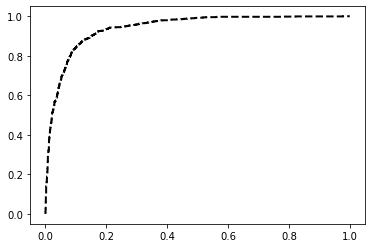

In [40]:
predit_prob_list = result["预测为1概率"].values
label_list = result["真实类别"].values

fpr, tpr, thersholds = roc_curve(label_list,predit_prob_list)

roc_auc = auc(fpr, tpr)
print("___AUC___ :",round(roc_auc,4))

plt.plot(fpr, tpr, 'k--', label='ROC (area = {})'.format(roc_auc), lw=2)

## 7.2 accuracy、recall、precision、f1_score评估（含混淆矩阵图）

In [41]:
# 自定义切割阈值

thresholds = np.arange(0, 1, 0.1)

In [42]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [43]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

plt.figure(figsize = (10,10))
j = 1
accuracyList,recallList,precisionList,f1_scoreList = [],[],[],[]
for i in thresholds:
    y_pred = [predit_prob >i for predit_prob in predit_prob_list]
#     plt.subplot(3,3,j)
    j += 1
    cnf_matrix = confusion_matrix(label_list, y_pred) #计算混淆矩阵

    np.set_printoptions(precision = 2)
    accuracy = (cnf_matrix[1,1]+cnf_matrix[0,0])/(cnf_matrix[1,1]+cnf_matrix[0,1]+cnf_matrix[0,0]+cnf_matrix[1,0])
    recall = cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0])
    precision = cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[0,1])
    f1_score = 2 * precision * recall / (recall + precision)
    accuracyList.append(accuracy)
    recallList.append(recall)
    precisionList.append(precision)
    f1_scoreList.append(f1_score)
    print('Threshold:',i)
    print('accuracy:', accuracy)
    print('Recall:', recall)     
    print('Precision:', precision)
    print('f1_score:',f1_score)
    class_names = [0, 1]
#     plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Threshold>=%s' %i)
    print('\n')

Threshold: 0.0
accuracy: 0.3390625
Recall: 1.0
Precision: 0.3390625
f1_score: 0.5064177362893816


Threshold: 0.1
accuracy: 0.810625
Recall: 0.9483870967741935
Precision: 0.6516782773907537
f1_score: 0.7725225225225225


Threshold: 0.2
accuracy: 0.8628125
Recall: 0.9087557603686636
Precision: 0.7435897435897436
f1_score: 0.817917876399834


Threshold: 0.30000000000000004
accuracy: 0.87875
Recall: 0.8599078341013825
Precision: 0.7981180496150556
f1_score: 0.8278615794143744


Threshold: 0.4
accuracy: 0.880625
Recall: 0.8147465437788018
Precision: 0.8300469483568075
f1_score: 0.8223255813953487


Threshold: 0.5
accuracy: 0.869375
Recall: 0.7493087557603687
Precision: 0.8477580813347236
f1_score: 0.7954990215264188


Threshold: 0.6000000000000001
accuracy: 0.8590625
Recall: 0.6857142857142857
Precision: 0.8711943793911007
f1_score: 0.7674058793192368


Threshold: 0.7000000000000001
accuracy: 0.840625
Recall: 0.6064516129032258
Precision: 0.8879892037786775
f1_score: 0.7207009857612267


T

<Figure size 720x720 with 0 Axes>

In [44]:
evalResult = pd.DataFrame({'threshold':thresholds,
                   'accuracy':accuracyList,
                   'recall':recallList,
                   'precision':precisionList,
                  'f1_score':f1_scoreList})
evalResult.to_excel("result/test_data_evaluation.xlsx",index = True)